In [0]:
#importing libraries
from google.colab import files
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn_pandas import CategoricalImputer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

In [0]:
#uploading train set obtained from preprocessing step in zip format
uploaded = files.upload()

Saving train.zip to train.zip


In [0]:
#unzipping train data
!unzip /content/train.zip

Archive:  /content/train.zip
  inflating: train.psv               


In [0]:
#reading training set
train = pd.read_csv('/content/train.psv', sep = '|')
train.shape

(151028, 41)

In [0]:
#Fields of training set
train.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

In [0]:
#total number of sepsis(1) and non-sepsis(0)
train['SepsisLabel'].value_counts()

0    148905
1      2123
Name: SepsisLabel, dtype: int64

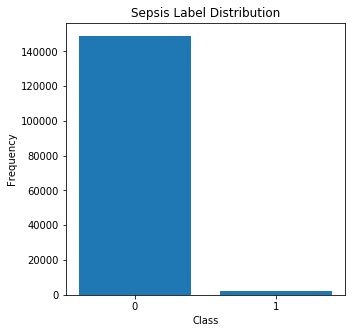

In [0]:
#plotting in graph to check whether the class is balanced or not
rcParams['figure.figsize'] = 5, 5

plt.bar(train['SepsisLabel'].value_counts().index,
        train['SepsisLabel'].value_counts())
plt.xticks([0,1])
plt.xlabel('Class')
plt.title('Sepsis Label Distribution')
_ = plt.ylabel('Frequency')

As we can see from the plot, it is a case of severe class imbalance .

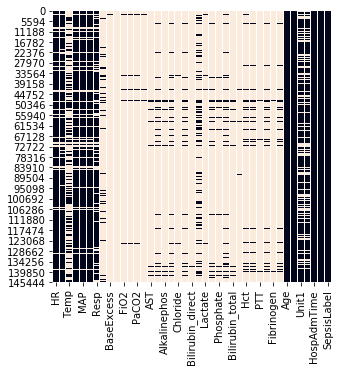

In [0]:
#checking for null in features/independent variable
sns.heatmap(train.isnull(), cbar=False)

In [0]:
#calculating the % of missing value
missing = (train.isnull().sum() / train.shape[0]) * 100
missing

HR                  12.232169
O2Sat               14.300659
Temp                66.469132
SBP                 14.109304
MAP                 15.001854
DBP                 14.129830
Resp                21.266917
EtCO2               92.966205
BaseExcess          99.786795
HCO3                99.830495
FiO2                97.769288
pH                  97.794449
PaCO2               97.791800
SaO2                98.109622
AST                 98.226157
BUN                 94.485791
Alkalinephos        98.216887
Calcium             93.199274
Chloride            99.414016
Creatinine          94.477845
Bilirubin_direct    99.768255
Glucose             77.743862
Lactate             98.163917
Magnesium           95.238631
Phosphate           97.111794
Potassium           92.336520
Bilirubin_total     98.214238
TroponinI           98.131472
Hct                 94.177901
Hgb                 94.120296
PTT                 98.992902
WBC                 94.751967
Fibrinogen          99.445798
Platelets 

Text(0.5, 1.0, 'Percentage of missing data in each feature')

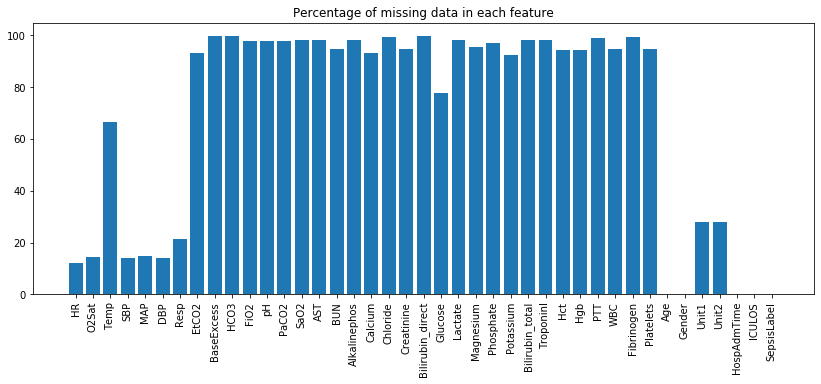

In [0]:
#ploting in figure
rcParams['figure.figsize'] = 14, 5
_ = plt.bar(missing.index, missing)
_ = plt.xticks(missing.index, rotation=90)

plt.title("Percentage of missing data in each feature")

In [0]:
#removing features with 90 % or more missing data
selected_new_cols = list(missing[missing < 90].index)
selected_new_cols

['HR',
 'O2Sat',
 'Temp',
 'SBP',
 'MAP',
 'DBP',
 'Resp',
 'Glucose',
 'Age',
 'Gender',
 'Unit1',
 'Unit2',
 'HospAdmTime',
 'ICULOS',
 'SepsisLabel']

In [0]:
refined_train = train[selected_new_cols]
refined_train.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,Glucose,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41,0,NaN,NaN,-8.88,1,0
1,66.0,100.0,NaN,127.0,87.0,67.0,10.0,179.0,41,0,NaN,NaN,-8.88,2,0
2,63.0,100.0,NaN,119.0,78.0,61.0,16.0,NaN,41,0,NaN,NaN,-8.88,3,0
3,60.0,99.0,NaN,121.0,76.0,59.0,18.0,NaN,41,0,NaN,NaN,-8.88,4,0
4,57.0,99.0,NaN,128.0,80.0,61.0,18.0,NaN,41,0,NaN,NaN,-8.88,5,0


In [0]:
#Univariate plots
categorical = refined_train.dtypes == object
categorical['Unit1'] = True
categorical['Unit2'] = True
categorical['Gender'] = True

In [0]:
cat_vars = list(categorical[categorical].index)
cont_vars = list(categorical[~categorical].index)
cont_vars.pop(-1)

'SepsisLabel'

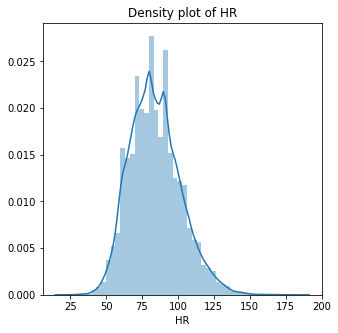

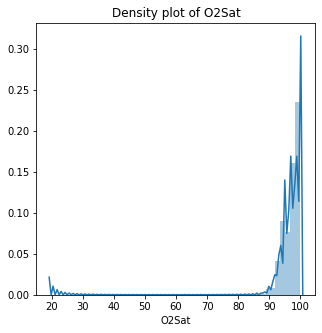

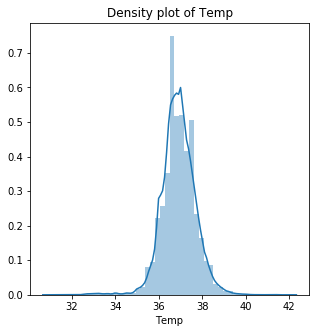

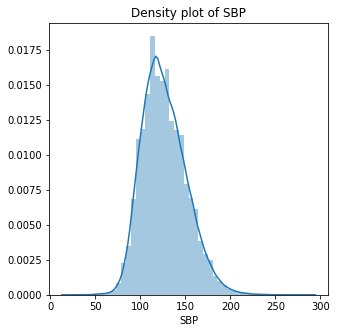

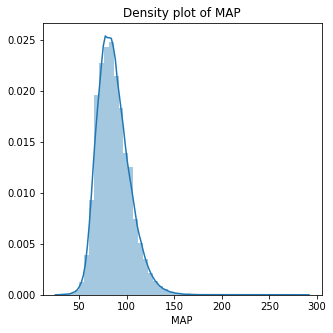

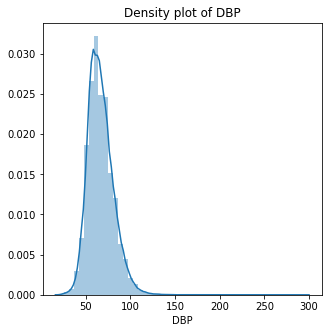

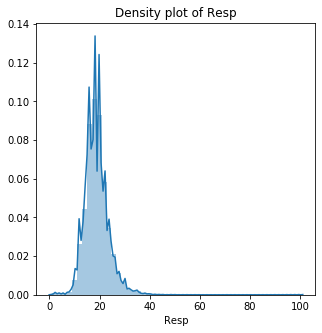

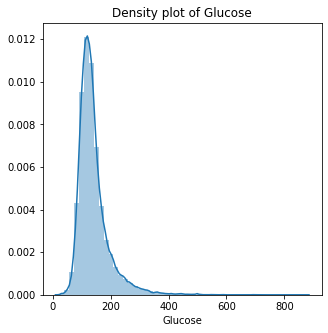

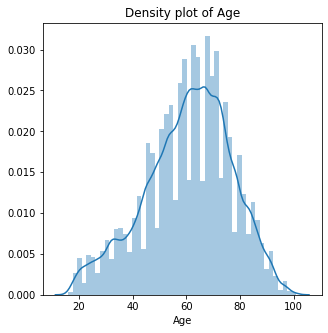

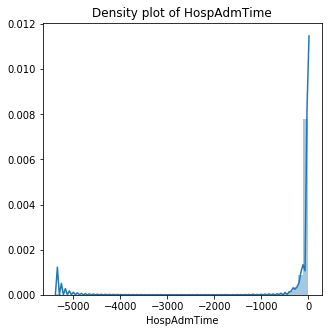

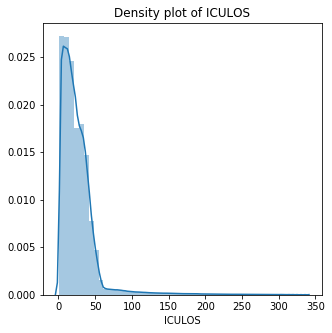

In [0]:
rcParams['figure.figsize'] = 5, 5
for i,var in enumerate(cont_vars):
    plt.figure(i)
    plt.title("Density plot of " + str(var))
    sns.distplot(refined_train[var].dropna(), axlabel=var);

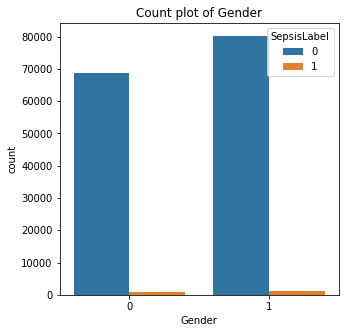

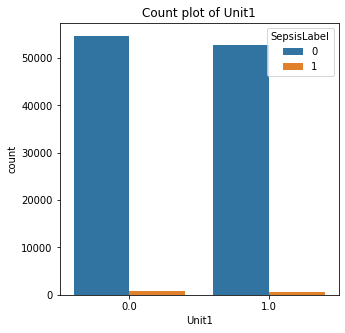

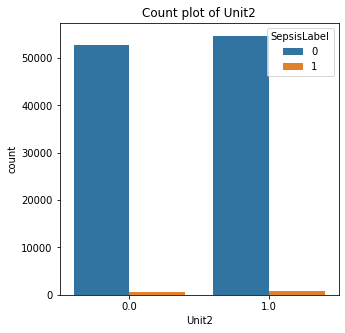

In [0]:
for i,var in enumerate(cat_vars):
    plt.figure(i)
    plt.title("Count plot of " + str(var))
    sns.countplot(refined_train[var].dropna(), hue='SepsisLabel', data= refined_train);

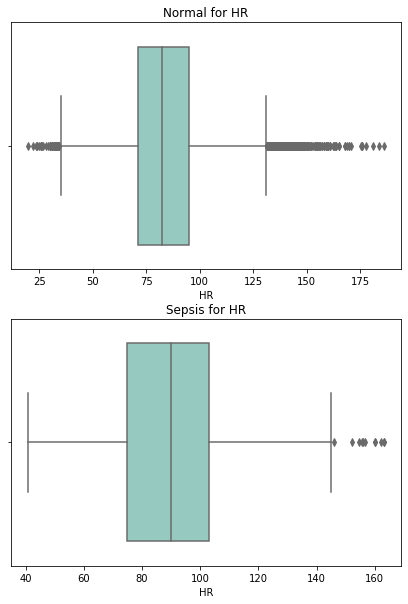

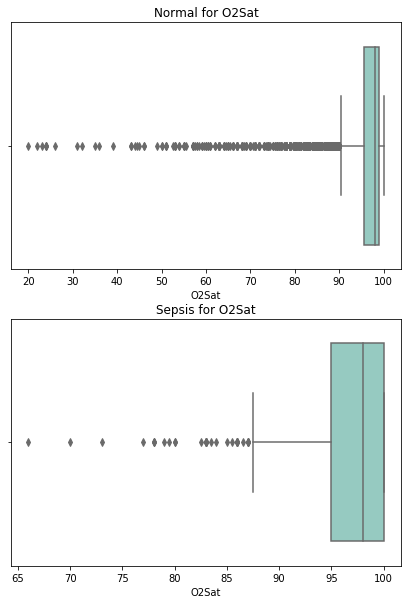

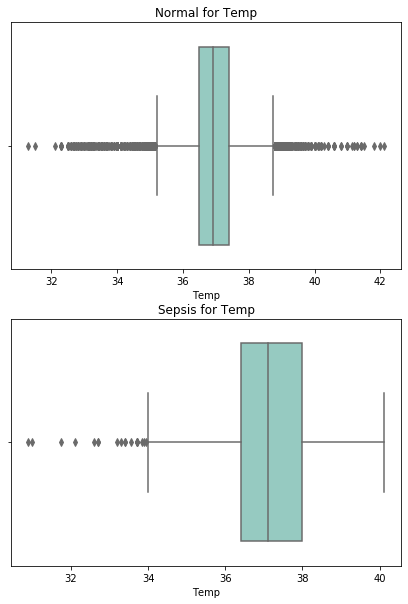

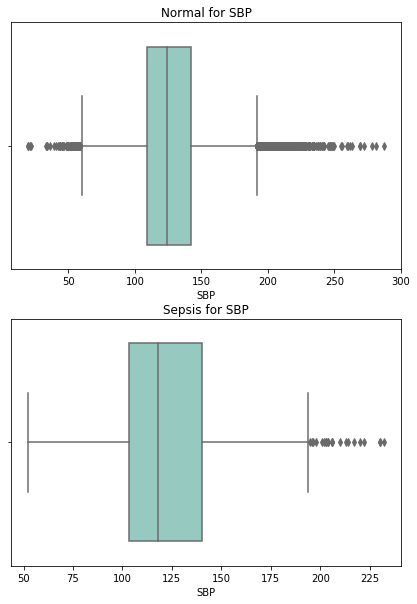

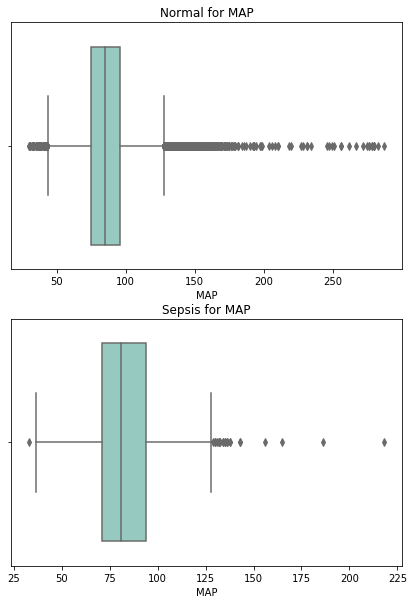

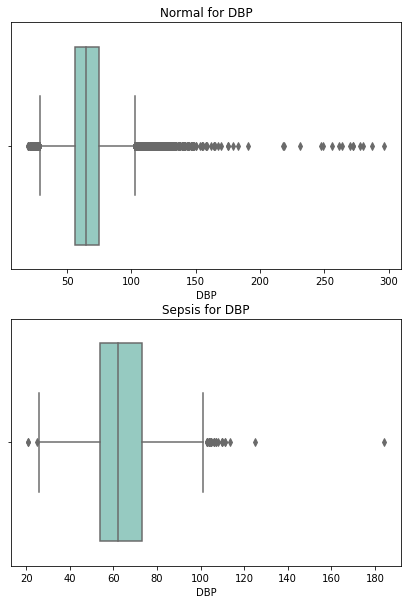

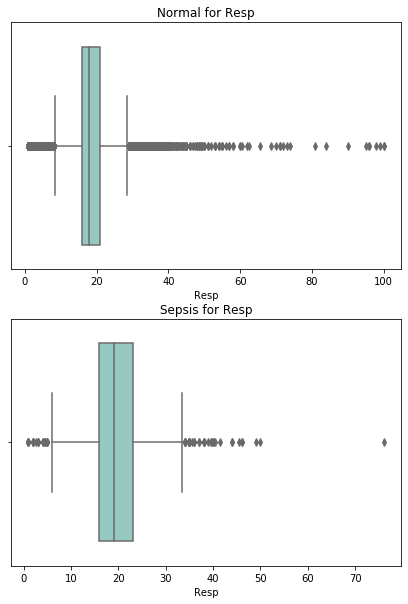

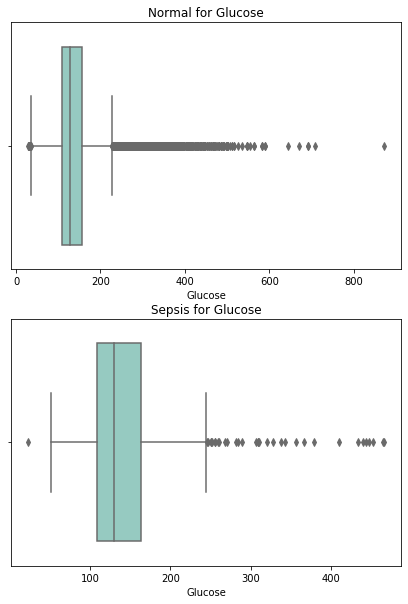

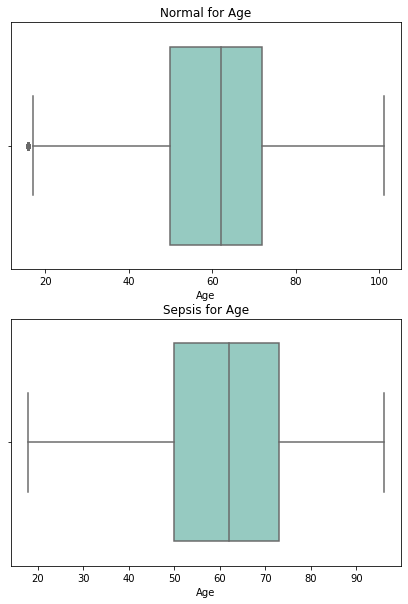

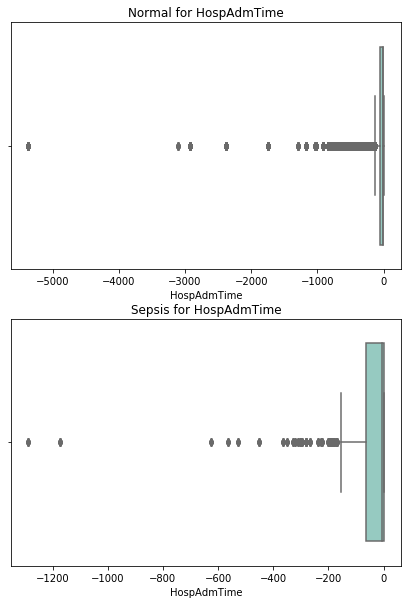

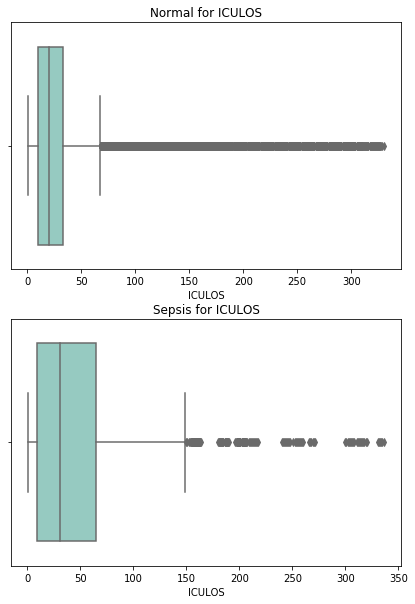

In [0]:
for i,var in enumerate(cont_vars):
    temp = refined_train[[var,'SepsisLabel']].dropna()
    temp1 = temp[temp['SepsisLabel']==0]
    temp2 = temp[temp['SepsisLabel']==1]
    fig, ax = plt.subplots(2, 1, figsize=(7, 10))

    sns.boxplot(temp1[var], ax=ax[0], palette='Set3')
    sns.boxplot(temp2[var], ax=ax[1], palette='Set3')
    ax[0].set_title("Normal for " + var)
    ax[1].set_title("Sepsis for " + var)

In [0]:
features = cont_vars + cat_vars
features

['HR',
 'O2Sat',
 'Temp',
 'SBP',
 'MAP',
 'DBP',
 'Resp',
 'Glucose',
 'Age',
 'HospAdmTime',
 'ICULOS',
 'Gender',
 'Unit1',
 'Unit2']

In [0]:
X_train = refined_train[features]
y_train = refined_train['SepsisLabel']

In [0]:
categorical = X_train.dtypes == object
categorical['Unit1'] = True
categorical['Unit2'] = True
categorical['Gender'] = True

In [0]:
cont_scale_pipeline = make_pipeline(SimpleImputer(strategy = "median"), 
                                    StandardScaler())
cat_pipeline = make_pipeline(SimpleImputer(strategy = "constant", 
                                           fill_value = 999), 
                             OneHotEncoder(handle_unknown="ignore"))
preprocess_trans_scale = make_column_transformer((cont_scale_pipeline, 
                                                  ~categorical), 
                                                 (cat_pipeline, categorical))

In [0]:
logistic_pipe_scale = make_pipeline(preprocess_trans_scale, 
                                    LogisticRegression(solver='lbfgs') )
rf_pipe_scale = make_pipeline(preprocess_trans_scale, RandomForestClassifier())
svc_pipe_scale = make_pipeline(preprocess_trans_scale, SVC())
gb_pipe_scale = make_pipeline(preprocess_trans_scale, GradientBoostingClassifier())
dt_pipe_scale = make_pipeline(preprocess_trans_scale, DecisionTreeClassifier() )
gmm_pipe_scale = make_pipeline(preprocess_trans_scale, GaussianMixture(n_components=2))
mlp_pipe_scale = make_pipeline(preprocess_trans_scale, MLPClassifier() )

In [0]:
scores_logistic_pipe_scale = cross_validate(logistic_pipe_scale, X_train, 
                                             y_train, 
                                             cv=StratifiedKFold(3, shuffle=True)
                                             ,scoring=["average_precision", 
                                                       "roc_auc", "precision", 
                                                       "recall"])



scores_rf_pipe_scale = cross_validate(rf_pipe_scale, X_train, 
                                             y_train, 
                                             cv=StratifiedKFold(3, shuffle=True)
                                             ,scoring=["average_precision", 
                                                       "roc_auc", "precision", 
                                                       "recall"])



scores_gb_pipe_scale = cross_validate(gb_pipe_scale, X_train, 
                                             y_train, 
                                             cv=StratifiedKFold(3, shuffle=True)
                                             ,scoring=["average_precision", 
                                                       "roc_auc", "precision", 
                                                       "recall"])



scores_dt_pipe_scale = cross_validate(dt_pipe_scale, X_train, 
                                             y_train, 
                                             cv=StratifiedKFold(3, shuffle=True)
                                             ,scoring=["average_precision", 
                                                       "roc_auc", "precision", 
                                                       "recall"])


scores_gmm_pipe_scale = cross_validate(gmm_pipe_scale, X_train, 
                                             y_train, 
                                             cv=StratifiedKFold(3, shuffle=True)
                                             ,scoring=["average_precision", 
                                                       "roc_auc", "precision", 
                                                       "recall"])

scores_mlp_pipe_scale = cross_validate(mlp_pipe_scale, X_train, 
                                             y_train, 
                                             cv=StratifiedKFold(3, shuffle=True)
                                             ,scoring=["average_precision", 
                                                       "roc_auc", "precision", 
                                                       "recall"])

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilay

In [0]:
log_df = pd.DataFrame(scores_logistic_pipe_scale)
log_df['model'] = 'LogisticRegression'

dt_df = pd.DataFrame(scores_dt_pipe_scale)
dt_df['model'] = 'DecisionTree'

gb_df = pd.DataFrame(scores_gb_pipe_scale)
gb_df['model'] = 'GradientBoosting'

rf_df = pd.DataFrame(scores_rf_pipe_scale)
rf_df['model'] = 'RandomForest'

gmm_df = pd.DataFrame(scores_gmm_pipe_scale)
gmm_df['model'] = 'GMM'

mlp_df = pd.DataFrame(scores_mlp_pipe_scale)
mlp_df['model'] = 'MLP'




results = pd.concat([log_df, dt_df, gb_df, rf_df, gmm_df, mlp_df])

In [0]:
results

,fit_time,score_time,test_average_precision,test_roc_auc,test_precision,test_recall,model
0,0.963523,0.269713,0.053569,0.687319,0.666667,0.002825,LogisticRegression
1,0.886989,0.270725,0.042448,0.679502,0.000000,0.000000,LogisticRegression
2,0.857826,0.271001,0.052533,0.700130,0.833333,0.007072,LogisticRegression
0,1.382148,0.219115,0.223438,0.737268,0.447507,0.481638,DecisionTree
1,1.480529,0.253335,0.262015,0.762794,0.478481,0.533898,DecisionTree
2,1.462230,0.214679,0.246790,0.750532,0.471129,0.507779,DecisionTree
0,11.438302,0.417479,0.212914,0.813181,0.813953,0.049435,GradientBoosting
1,10.231200,0.414322,0.191832,0.829989,0.750000,0.046610,GradientBoosting
2,11.209931,0.433820,0.213506,0.839775,0.829787,0.055163,GradientBoosting
0,1.891596,0.534573,0.497393,0.907903,0.885496,0.163842,RandomForest
